# Results R1a: What sentiments and topics are present in the diary chunks (single level)?

## Resources

In [838]:
# Get Packages & Libraries
library(tidyverse)
library(rethinking)
library(extraDistr)

In [814]:
# Functions
factorize <- function(df){ # Create a function
  for(i in which(sapply(df, class) == "character")) # that looks for variables with the character class 
      df[[i]] = as.factor(df[[i]]) # and converts them to factor (i.e., categorical) class
  return(df)
}

unfactorize <- function(df){ # Create a function
  for(i in which(sapply(df, class) == "factor")) # that looks for variables with the character class 
      df[[i]] = as.character(df[[i]]) # and converts them to factor (i.e., categorical) class
  return(df)
}

st <- function(x){
    (x-mean(x,na.rm=TRUE))/sd(x,na.rm=TRUE)
}

In [2]:
# Get Data
# View Data
df2  <- read.csv("20240702_PhD_FinalData-DiaryChk.csv")
df2[df2 == ''] <- NA #replace blank cells with NA
#df2 <- df2[-c(1)] #drop the index column
df2 <- factorize(df2)
colnames(df2)

ERROR: Error in factorize(df2): could not find function "factorize"


## Sentiment


#### Actual Data

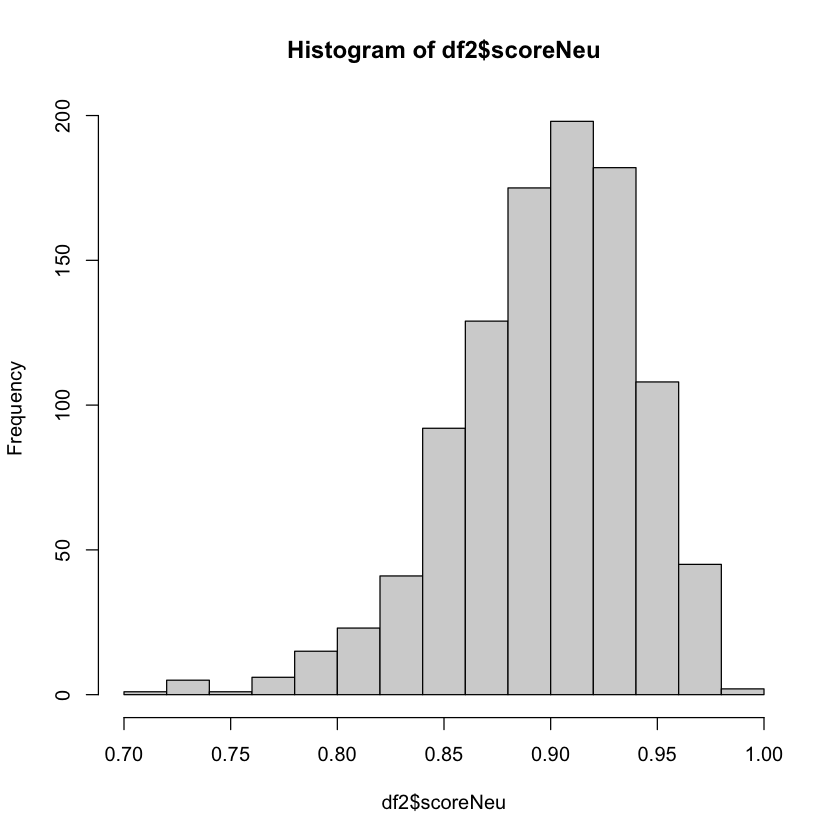

In [6]:
hist(df2$scoreNeu)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.99160 -0.15870 -0.01155 -0.07138  0.08942  0.98860 

[1] 0.3619947

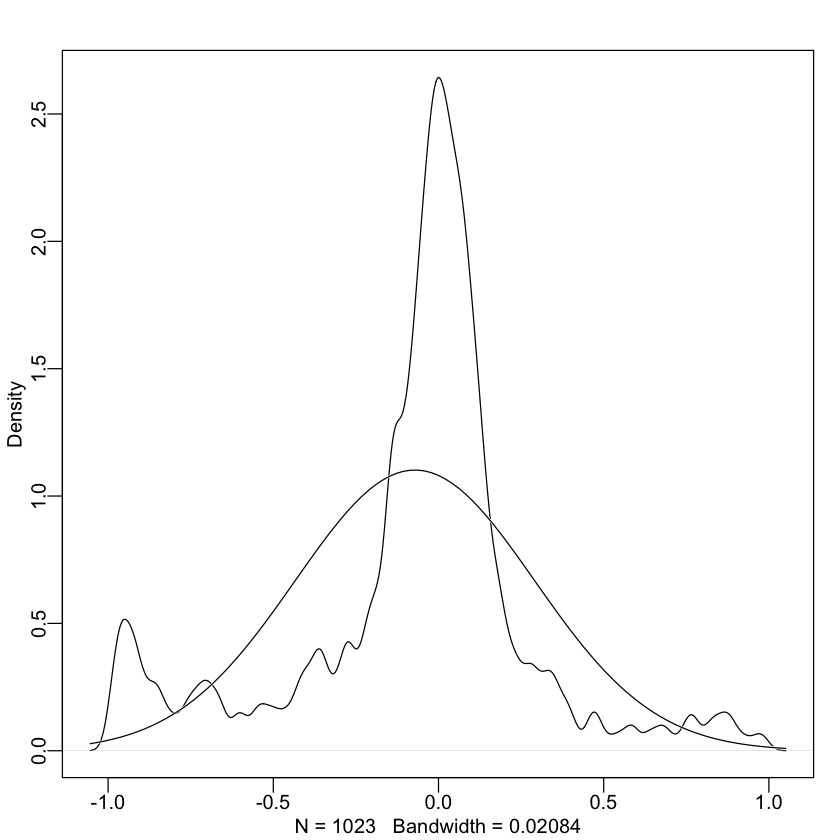

In [795]:
summary(df2$scoreCom)
dens(df2$scoreCom,norm.comp=TRUE)
sd(df2$scoreCom)

#### Model Specification & Prior Predictive Checks

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-1.1345295 -0.1374152 -0.0028062 -0.0009739  0.1387086  0.9603736 

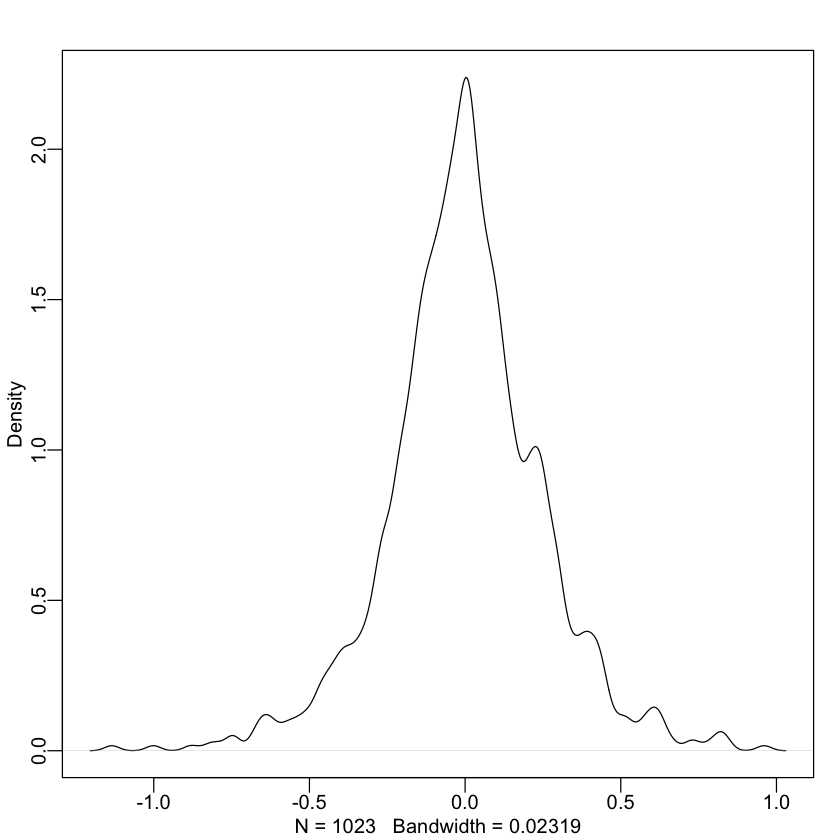

In [794]:
sample_mu <- rnorm( 1023 , 0 , .1 )
sample_sigma <- runif( 1023 , 0 , .4 )
prior_h <- rnorm( 1023 , sample_mu , sample_sigma )
dens(prior_h)
summary(prior_h)

In [793]:
#sample_mu <- rnorm( 1023 , 0 , .1 )
#sample_sigma <- rhnorm( 1023 , .4)
#set.seed(100)
#prior_h <- rnorm( 1023 , sample_mu , sample_sigma )
#dens(prior_h)
#summary(prior_h)

In [765]:
#sample_mu <- rnorm( 1023 , 0 , .1 )
#sample_sigma <- rexp( 1023 , 5)
#set.seed(100)
#prior_h <- rnorm( 1023 , sample_mu , sample_sigma )
#dens(prior_h)
#summary(prior_h)

$$compoundSentiment_{i} \sim Normal(\mu, \sigma)$$
$$\mu \sim Normal(0,0.1)$$
$$\sigma \sim Uniform(0,0.4)$$

See McElreath (2020, p. 82), 20190117_PM_Slides.pdf (slides 7-8) for model specification.

In [301]:
# Define them model
m2 <- alist(
    df2$scoreCom ~ dnorm(mu,sigma),
    mu ~ dnorm(0,.1),
    sigma ~ dunif(0,.4)
)

f2 <- quap(m2,data=df2)

#m2 <- readRDS("20240826_PhD_DiaChkSen_01.rds")
precis(f2, prob=.95)

,mean,sd,2.5%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,-0.07048127,0.011240748,-0.09251273,-0.04844981
sigma,0.36181916,0.007998839,0.34614172,0.37749660


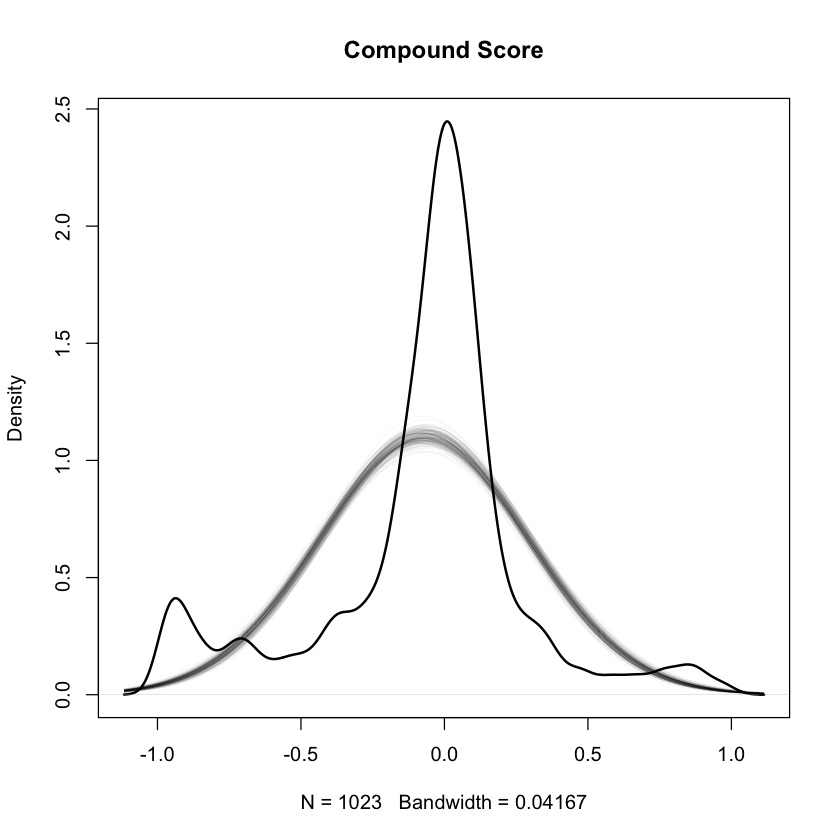

In [778]:
# Get coefficients
mu_fit <- coef(m2)[[1]]
sigma_fit <- coef(m2)[[2]]

# draw 5000 samples from the joint posterior
coef_samp <- extract.samples(m2,5000)
# convert to dataframe
coef_samp <- as.data.frame(coef_samp)

# actual data
den <- density(df2$scoreCom)
plot(den,lwd=2,,main="Compound Score")

# samples from the posterior
for(i in 1:200){
    y_fit <- dnorm(den$x,coef_samp[i,1],coef_samp[i,2])
    lines(den$x,y_fit,lwd=.5,col='#00000010')    
}

In [302]:
saveRDS(f2, file = "20240826_PhD_DiaChkSen_01.rds")

Code below adapted from file:///Users/alaynemoody/Dropbox/SOCI620_Resources/20200310_PM_Code17.html

## Topics

#### Actual Data & Transformation

In [816]:
# Get counts for topic number
table(as.factor(df2$topicNumber))

# Create new variable with topic labels that match pyLDAvis label numbers
df2$topicLabel <- as.character(df2$topicNumber)
df2$topicLabel[df2$topicLabel=="0"]  <- "01 Housework"
df2$topicLabel[df2$topicLabel=="1"]  <- "02 Places"
df2$topicLabel[df2$topicLabel=="2"]  <- "03 Business"
df2$topicLabel[df2$topicLabel=="3"]  <- "04 Girl Privilege"
df2$topicLabel[df2$topicLabel=="4"]  <- "05 Working Boy"
df2$topicLabel[df2$topicLabel=="5"]  <- "06 Weather"
df2$topicLabel[df2$topicLabel=="6"]  <- "07 People"
df2$topicLabel[df2$topicLabel=="7"]  <- "08 Politics"
df2$topicLabel[df2$topicLabel=="8"]  <- "09 Outback"
df2$topicLabel[df2$topicLabel=="9"]  <- "10 Home"
df2$topicLabel <- as.factor(df2$topicLabel)

# Check
df2 %>% 
select(topicNumber, topicLabel) %>% 
unique() %>% 
arrange(topicLabel)

table(df2$topicLabel)
sum(is.na(df2$topicLabel))


  0   1   2   3   4   5   6   7   8   9 
135 111 100 144 107  71  89 109  93  64 

topicNumber,topicLabel
<int>,<fct>
0,01 Housework
1,02 Places
2,03 Business
3,04 Girl Privilege
4,05 Working Boy
5,06 Weather
6,07 People
7,08 Politics
8,09 Outback



     01 Housework         02 Places       03 Business 04 Girl Privilege 
              135               111               100               144 
   05 Working Boy        06 Weather         07 People       08 Politics 
              107                71                89               109 
       09 Outback           10 Home 
               93                64 

[1] 0

#### Model Specification and Prior Predictive Checks

The explanation in McElreath and Kurz for this type of distribution is rather confusing. I have essentially used an intercept only version of example m10.17 in McElreath (2015, p. 325, R Code 10.58) and which Kurz (2023, Version translates in section 10.3.1.1.2, b10.17., version 1.3.0). I also follow the notation provided in https://soci620.netlify.app/slides/soci620_13_multinomialRegression.pdf

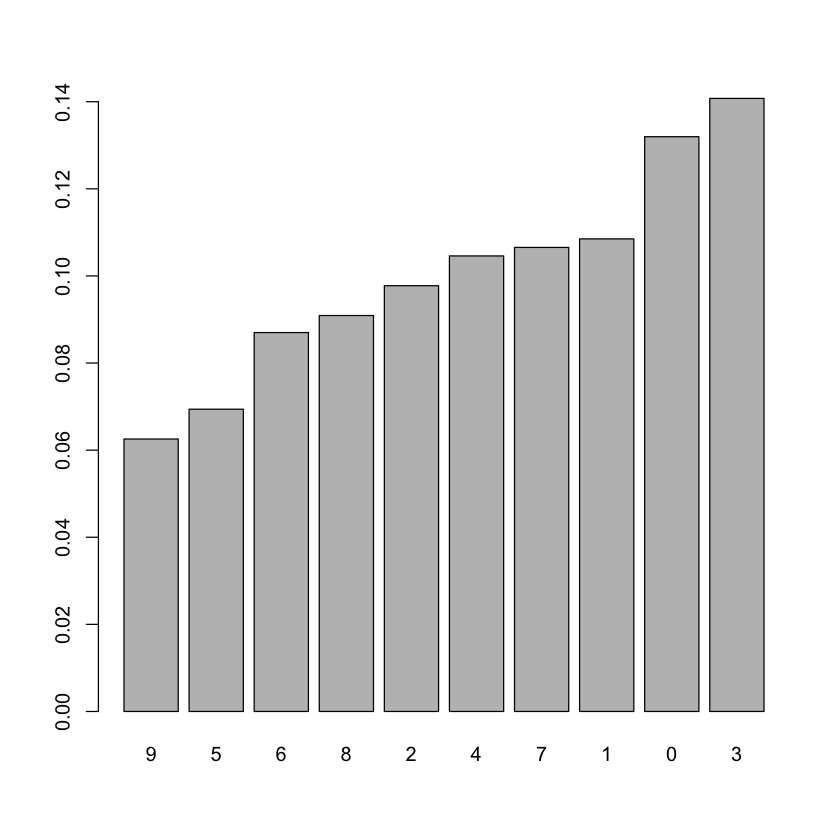

In [817]:
barplot(prop.table(sort(table(df2$topicNumber), decreasing = FALSE)))

#### Model Specification & Prior Predictive Checks

See https://www.statisticssolutions.com/wp-content/uploads/2010/12/295.png for softmax to probability conversion. Because the prior for this model represents the intercept for each topic, I choose a normal distribution with a mean of -2 and a standard deviation of 1. Also using the inverse logit function to get values representing the minimum and maximum means shown above. 

$$letterTopic_i \sim Categorical(softmax(topic_{1i}, topic_{2i}, ... , topic_{ki})$$
$$topic_{1i} = 0$$
$$topic_{2i}, ... ,topic_{ki} = \alpha_{topic_2}, ... ,\alpha_{topic_k} $$
$$\alpha_{topic_2}, ... ,\alpha_{topic_k} \sim Normal(-2,1)$$

In [818]:
m4 <- alist(
  topicLabel ~ dcategorical(softmax(0,
                                    t_02Places, 
                                    t_03Business,
                                    t_04GirlPrivilege,
                                    t_05WorkingBoy,
                                    t_06Weather,
                                    t_07People,
                                    t_08Politics,
                                    t_09Outback,
                                    t_10Home
                                   )),
    t_02Places <- a_02Places,
    t_03Business <- a_03Business,
    t_04GirlPrivilege <- a_04GirlPrivilege, 
    t_05WorkingBoy <- a_05WorkingBoy, 
    t_06Weather <- a_06Weather, 
    t_07People <- a_07People, 
    t_08Politics <- a_08Politics,
    t_09Outback <- a_09Outback,
    t_10Home <- a_10Home,
  
    c(a_02Places, 
    a_03Business,
    a_04GirlPrivilege,
    a_05WorkingBoy,
    a_06Weather,
    a_07People,
    a_08Politics,
    a_09Outback,
    a_10Home) ~ dnorm(-2,1)
) #(20190219_PM_Code.html, McElreath (2015, p. 325, R Code 10.58)

In [819]:
# Give it starting values
st <- list(a_02Places = -2, 
    a_03Business = -2,
    a_04GirlPrivilege = -2,
    a_05WorkingBoy = -2,
    a_06Weather = -2,
    a_07People = -2,
    a_08Politics = -2,
    a_09Outback = -2,
    a_10Home = -2)

In [820]:
f4 <- quap(m4,data=df2, start = st)
precis(f4,prob=.95)

,mean,sd,2.5%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a_02Places,-0.30920432,0.1236425,-0.5515391,-0.06686956
a_03Business,-0.41420825,0.1275483,-0.6641983,-0.16421815
a_04GirlPrivilege,-0.04722994,0.1150601,-0.2727437,0.17828379
a_05WorkingBoy,-0.34613144,0.1249841,-0.5910958,-0.10116708
a_06Weather,-0.75830563,0.1424451,-1.0374929,-0.47911839
a_07People,-0.53137479,0.1322473,-0.7905748,-0.27217481
a_08Politics,-0.32749604,0.1243028,-0.5711250,-0.08386708
a_09Outback,-0.48718016,0.1304315,-0.7428211,-0.23153920
a_10Home,-0.86243836,0.1476422,-1.1518118,-0.57306496


In [821]:
cf <- coef(f4)

s1 <- c(
    0,
    cf['a_02Places'],
    cf['a_03Business'],
    cf['a_04GirlPrivilege'],
    cf['a_05WorkingBoy'],
    cf['a_06Weather'],
    cf['a_07People'],
    cf['a_08Politics'],
    cf['a_09Outback'],
    cf['a_10Home']
)

p1 <- softmax(s1[1],s1[2],s1[3],s1[4],s1[5],s1[6],s1[7],s1[8],s1[9],s1[10])
names(p1) <- c('Housework',
               "Places",
               "Business",
               "Girl Privilege",
               "Working Boy",
               "Weather",
               "People",
               "Politics",
               "Outback",
               "Home"
              )
sum(p1)

p1 <- round(p1, digits = 3)
topicVis  <- t(data.frame(as.list(p1)))
colnames(topicVis)  <-  "Probability"
topicVis

[1] 1

,Probability
Housework,0.146
Places,0.107
Business,0.096
Girl.Privilege,0.139
Working.Boy,0.103
Weather,0.068
People,0.086
Politics,0.105
Outback,0.089
Home,0.061


#### Visualization

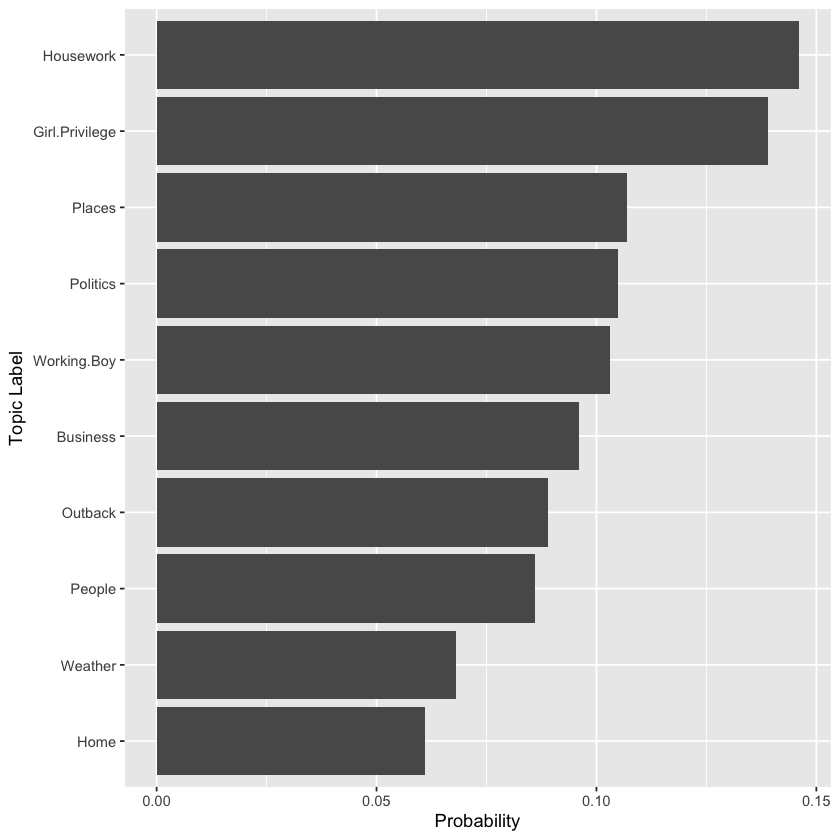

In [822]:
# Make a graph

topicVis <- as.data.frame(topicVis)

# Barplot
p  <- ggplot(topicVis, aes(x=reorder(rownames(topicVis), Probability), y=Probability)) + 
  geom_bar(stat = "identity") +
  coord_flip() + xlab("Topic Label")
p

In [823]:
ggsave("20240828_PhD_DiaChkTop01.png")

Saving 7 x 7 in image


In [824]:
saveRDS(f4, file = "20240828_PhD_DiaChkTop_01.rds")

## Socials

### External Person Mentions

#### Actual Data

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.003704 0.027675 0.037415 0.039257 0.048689 0.111913 

[1] 0.01616384

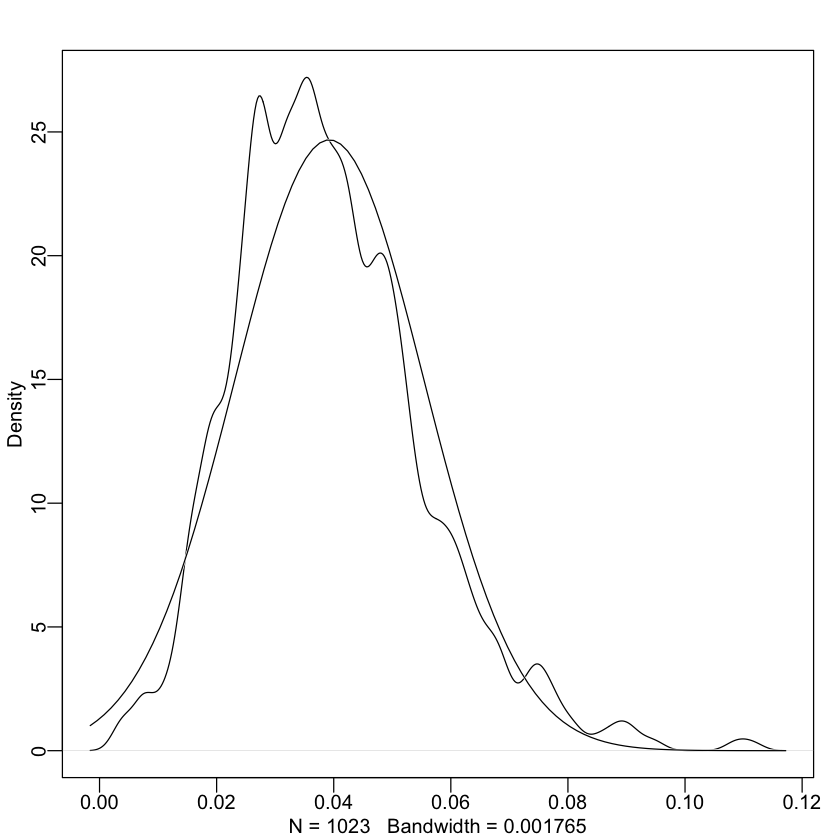

In [594]:
# Create a new token that reflects the rate of total individuals relative to total tokens
df2$mentsRate <- df2$mentsTot/df2$totalTokens
summary(df2$mentsRate)
dens(df2$mentsRate,norm.comp=TRUE)
sd(df2$mentsRate)

#### Model Specification and Prior Predictive Checks

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.02515  0.03009  0.03983  0.04000  0.04880  0.09424 

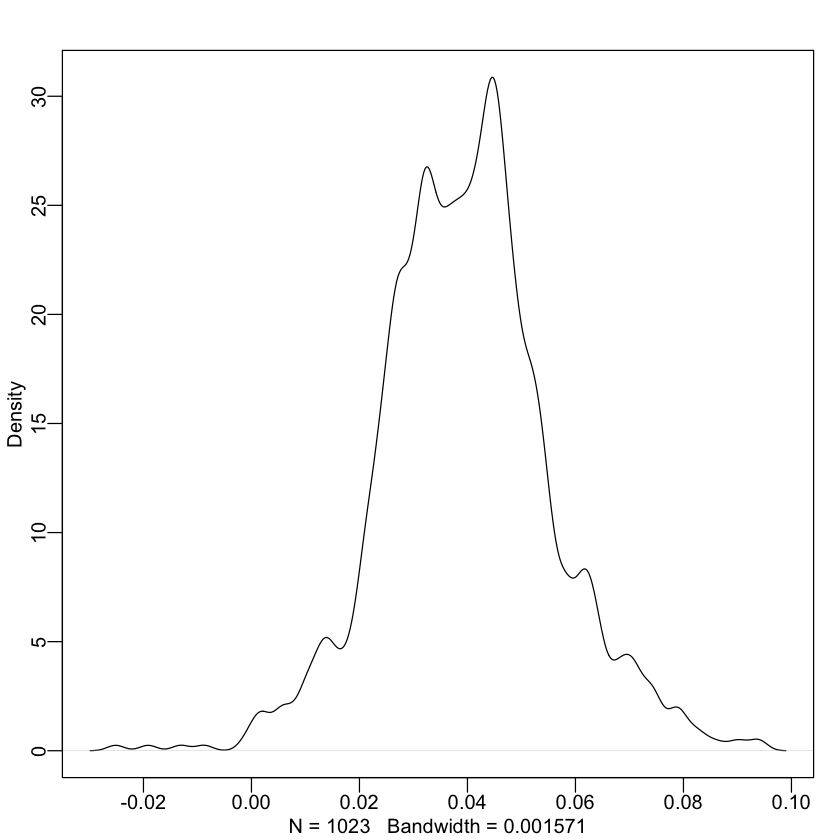

In [677]:
sample_mu <- rnorm( 1023 , .04 , .01 )
sample_sigma <- runif( 1023 , 0, .02 )
set.seed(100)
prior_h <- rnorm( 1023 , sample_mu , sample_sigma )
dens(prior_h)
summary(prior_h)

In [776]:
#sample_mu <- rnorm( 1023 , .04 , .01 )
#sample_sigma <- rhnorm( 1023 , .02)
#set.seed(100)
#prior_h <- rnorm( 1023 , sample_mu , sample_sigma )
#dens(prior_h)
#summary(prior_h)

In [777]:
#sample_mu <- rnorm( 1023 , .04 , .01 )
#sample_sigma <- rexp( 1023 , 150)
#set.seed(100)
#prior_h <- rnorm( 1023 , sample_mu , sample_sigma )
#dens(prior_h)
#summary(prior_h)

$$mentionsRate_{i} \sim Normal(\mu, \sigma)$$
$$\mu \sim normal(0.04,0.01)$$
$$\sigma \sim uniform(0,.02)$$

In [680]:
# Define them model
m7 <- alist(
    df2$mentsRate ~ dnorm(mu,sigma),
    mu ~ dnorm(.04,.01),
    sigma ~ dunif(0,.02)
)

f7 <- quap(m7,data=df2)
precis(f7, prob=.95)

,mean,sd,2.5%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,0.03928508,0.0005047107,0.03829587,0.04027430
sigma,0.01616341,0.0003514448,0.01547459,0.01685223


In [681]:
saveRDS(f7, file = "20240828_PhD_DiaChkSocM_01.rds")

### First Person Pronouns (All)

### Actual Data

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.01495 0.02465 0.02728 0.03521 0.09343 

[1] 0.01653195

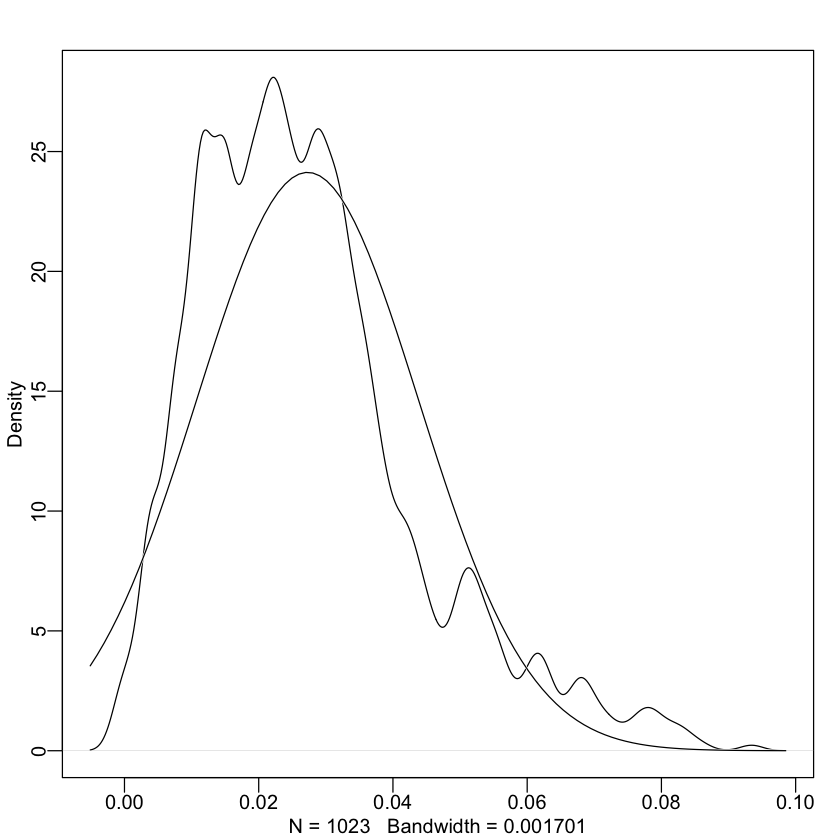

In [840]:
# Create a new token that reflects the rate of all 1st person pronouns relative to total tokens
df2$fppAllRate <- df2$fppAll_Ct/df2$totalTokens
summary(df2$fppAllRate)
dens(df2$fppAllRate,norm.comp=TRUE)
sd(df2$fppAllRate)

#### Model Specification and Prior Predictive Checks

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.01159  0.02164  0.03011  0.02993  0.03698  0.06895 

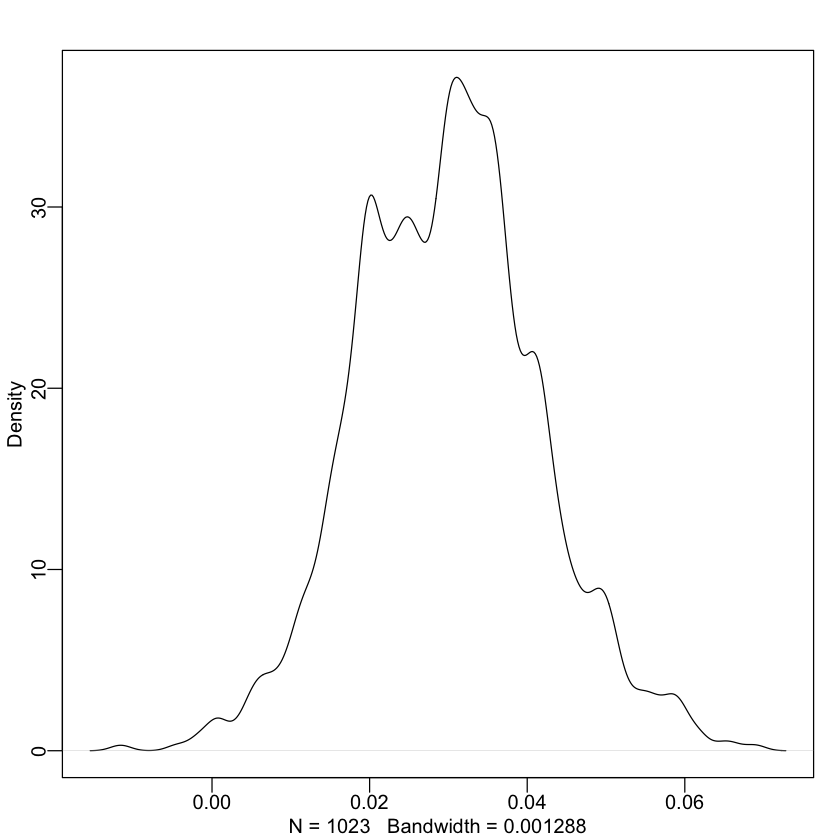

In [829]:
sample_mu <- rnorm( 1023 , .03 , .01 )
sample_sigma <- runif( 1023 , 0, .01 )
set.seed(100)
prior_h <- rnorm( 1023 , sample_mu , sample_sigma )
dens(prior_h)
summary(prior_h)

$$rateFFPAll_{i} \sim Normal(\mu, \sigma)$$
$$\mu \sim normal(0.03,0.01)$$
$$\sigma \sim uniform(0,0.01)$$

In [853]:
# Define them model
m8 <- alist(
    df2$fppAllRate ~ dnorm(mu,sigma),
    mu ~ dnorm(0.03,0.01),
    sigma ~ dunif(0,.02)
)

f8 <- quap(m8,data=df2)
precis(f8, prob=.95)

,mean,sd,2.5%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,0.02728508,0.0005169626,0.02627185,0.02829830
sigma,0.01655686,0.0003611173,0.01584908,0.01726464


In [854]:
saveRDS(f8, file = "20240828_PhD_DiaChkSocFAll_01.rds")

### Self Reference Rate

#### Actual Data

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.01111 0.01845 0.02189 0.02827 0.07958 

[1] 0.01506564

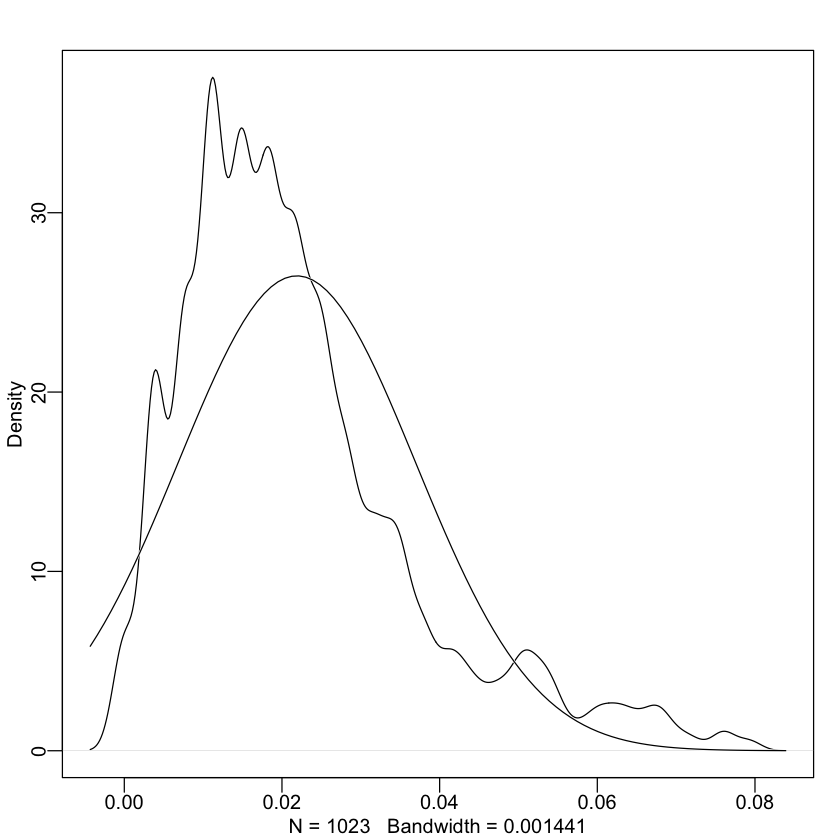

In [719]:
# Create a new token that reflects the rate of total individuals relative to total tokens
df2$fppSubRate <- df2$fppSub_Ct/df2$totalTokens
summary(df2$fppSubRate)
dens(df2$fppSubRate,norm.comp=TRUE)
sd(df2$fppSubRate)

#### Model Specification and Prior Predictive Checks

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.03250  0.01042  0.01956  0.02014  0.02917  0.08493 

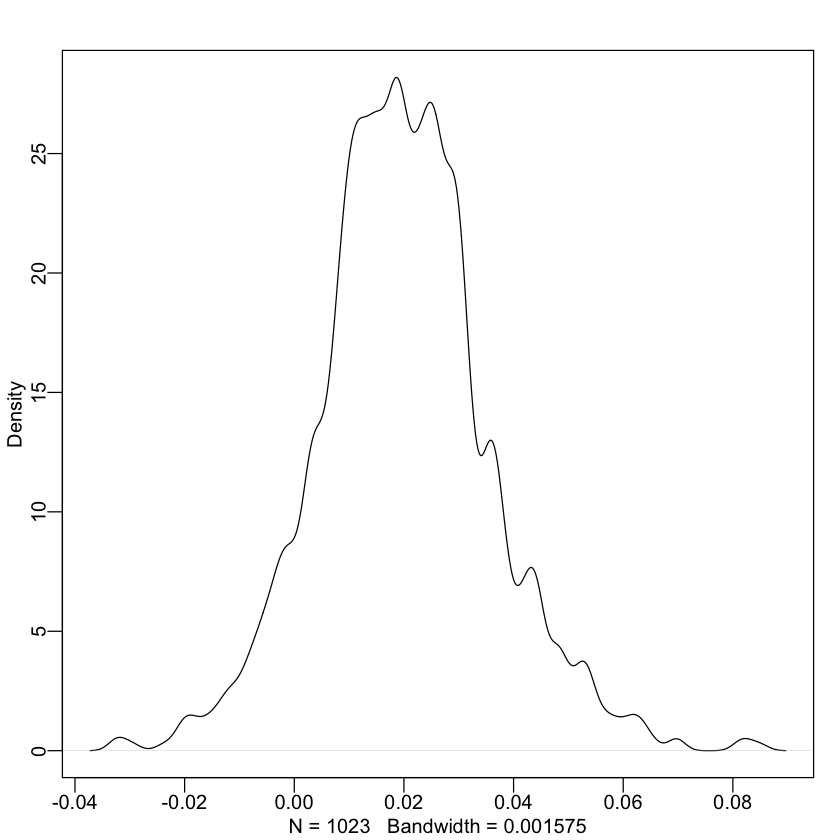

In [714]:
sample_mu <- rnorm( 1023 , .02 , .01 )
sample_sigma <- runif( 1023 , 0, .02 )
set.seed(100)
prior_h <- rnorm( 1023 , sample_mu , sample_sigma )
dens(prior_h)
summary(prior_h)

$$rateFFPSub_{i} \sim Normal(\mu, \sigma)$$
$$\mu \sim normal(0.02,0.01)$$
$$\sigma \sim uniform(0,.02)$$

In [722]:
# Define them model
m9 <- alist(
    df2$fppSubRate ~ dnorm(mu,sigma),
    mu ~ dnorm(0.02,0.01),
    sigma ~ dunif(0,.02)
)

f9 <- quap(m9,data=df2)
precis(f9, prob=.95)

,mean,sd,2.5%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,0.02188913,0.0004719741,0.02096407,0.02281418
sigma,0.01511263,0.0003293092,0.01446720,0.01575807


In [723]:
saveRDS(f9, file = "20240828_PhD_DiaChkSocFSub_01.rds")

## References

<ul>
<li>See McElreath (2020, p. 82), 20190117_PM_Slides.pdf (slides 7-8) for model specification.</li>
<li>See McElreath (2020, pp. 82-84) for prior prediction</li>
<li>See McElreath (2020, p. 118) for explanation of exponential prior</li>
</ul>

## Prior Prediction Aids

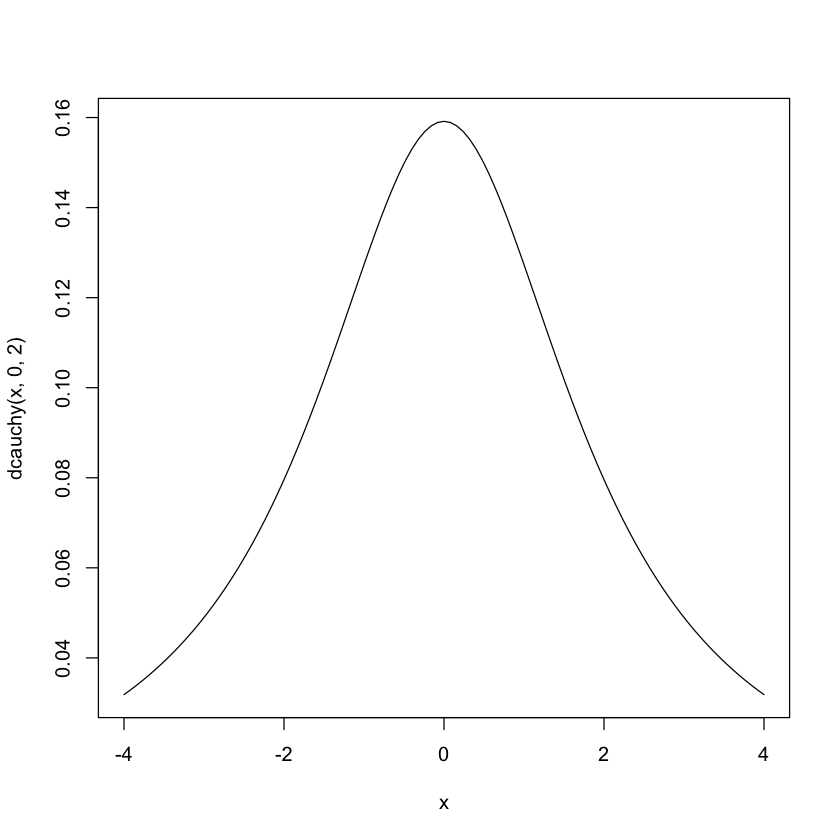

In [807]:
# Mu
#curve( dnorm( x , .02 , .01 ) , from=0 , to=.08 ) # Normal
# Sigma
curve(dcauchy(x, 0, 2), from=-4, to=4) # Cauchy
#curve( dunif( x , 0 , .02 ) , from=0 , to=.1 ) # Uniform
#curve( dexp( x , 100) , from=0 , to=.1 )  # Exponential
#curve( dhnorm( x ,.02) , from=0 , to=.1 )  # Half-Normal